<a href="https://colab.research.google.com/github/jproney/AF2Rank/blob/master/figures/AF2Rank_design_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
git clone -q https://github.com/jproney/AF2Rank.git
wget -qnc https://files.ipd.uw.edu/pub/decoyset/natives.zip
unzip -qqo natives.zip

In [ ]:
#@title ## setup
%%bash
if [ ! -d params ]; then
  # get code
  pip -q install git+https://github.com/sokrypton/ColabDesign.git
  # for debugging
  ln -s /usr/local/lib/python3.7/dist-packages/colabdesign colabdesign

  # alphafold params
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2022-03-02.tar | tar x -C params

  wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
  g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
fi

In [ ]:
#@title import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from colabdesign import clear_mem, mk_af_model
from colabdesign.shared.utils import copy_dict

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import jax

def tmscore(x,y):
  # save to dumpy pdb files
  for n,z in enumerate([x,y]): 
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n" 
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')

  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  
  return o
  
def plot_me(scores, x="tm_i", y="composite", 
            title=None, diag=False, scale_axis=True, dpi=100, **kwargs):
  def rescale(a,amin=None,amax=None):  
    a = np.copy(a)
    if amin is None: amin = a.min()
    if amax is None: amax = a.max()
    a[a < amin] = amin
    a[a > amax] = amax
    return (a - amin)/(amax - amin)

  plt.figure(figsize=(5,5), dpi=dpi)
  if title is not None: plt.title(title)
  x_vals = np.array([k[x] for k in scores])
  y_vals = np.array([k[y] for k in scores])
  c = rescale(np.array([k["plddt"] for k in scores]),0.5,0.9)
  plt.scatter(x_vals, y_vals, c=c*0.75, s=5, vmin=0, vmax=1, cmap="gist_rainbow",
              **kwargs)
  if diag:
    plt.plot([0,1],[0,1],color="black")
  
  labels = {"tm_i":"TMscore of Input",
            "tm_o":"TMscore of Output",
            "tm_io":"TMscore between Input and Output",
            "ptm":"Predicted TMscore (pTM)",
            "i_ptm":"Predicted interface TMscore (ipTM)",
            "plddt":"Predicted LDDT (pLDDT)",
            "composite":"Composite"}

  plt.xlabel(labels.get(x,x));  plt.ylabel(labels.get(y,y))
  if scale_axis:
    if x in labels: plt.xlim(-0.1, 1.1)
    if y in labels: plt.ylim(-0.1, 1.1)
  
  print(spearmanr(x_vals,y_vals).correlation)

class af2rank:
  def __init__(self, pdb, chain=None, model_name="model_1_ptm", model_names=None):
    self.args = {"pdb":pdb, "chain":chain,
                 "use_multimer":("multimer" in model_name),
                 "model_name":model_name,
                 "model_names":model_names}
    self.reset()

  def reset(self):
    self.model = mk_af_model(protocol="fixbb",
                             use_templates=True,
                             use_multimer=self.args["use_multimer"],
                             use_alphafold=True, use_openfold=False,
                             debug=False,
                             model_names=self.args["model_names"])
    
    self.model.prep_inputs(self.args["pdb"], chain=self.args["chain"])
    self.model.set_seq(mode="wildtype")
    self.wt_batch = copy_dict(self.model._inputs["batch"])
    self.wt = self.model._wt_aatype

  def set_pdb(self, pdb, chain=None):
    if chain is None: chain = self.args["chain"]
    self.model.prep_inputs(pdb, chain=chain)
    self.model.set_seq(mode="wildtype")
    self.wt = self.model._wt_aatype

  def set_seq(self, seq):
    self.model.set_seq(seq=seq)
    self.wt = self.model._params["seq"][0].argmax(-1)

  def _get_score(self):
    score = copy_dict(self.model.aux["log"])

    score["plddt"] = score["plddt"]
    score["pae"] = 31.0 * score["pae"]
    score["rmsd_io"] = score.pop("rmsd",None)

    i_xyz = self.model._inputs["batch"]["all_atom_positions"][:,1]
    o_xyz = np.array(self.model.aux["atom_positions"][:,1])

    # TMscore to input/output
    if hasattr(self,"wt_batch"):
      n_xyz = self.wt_batch["all_atom_positions"][:,1]
      score["tm_i"] = tmscore(n_xyz,i_xyz)["tms"]
      score["tm_o"] = tmscore(n_xyz,o_xyz)["tms"]

    # TMscore between input and output
    score["tm_io"] = tmscore(i_xyz,o_xyz)["tms"]

    # composite score
    score["composite"] = score["ptm"] * score["plddt"] * score["tm_io"]
    return score
  
  def predict(self, pdb=None, seq=None, chain=None, 
              input_template=True, model_name=None,
              rm_seq=True, rm_sc=True, rm_ic=False,
              recycles=1, iterations=1,
              output_pdb=None, extras=None, verbose=True):
    
    if model_name is not None:
      self.args["model_name"] = model_name
      if "multimer" in model_name: 
        if not self.args["use_multimer"]:
          self.args["use_multimer"] = True
          self.reset()
      else:
        if self.args["use_multimer"]:
          self.args["use_multimer"] = False
          self.reset()
  
    if pdb is not None: self.set_pdb(pdb, chain)
    if seq is not None: self.set_seq(seq)

    # set template sequence
    self.model._inputs["batch"]["aatype"] = self.wt

    # set other options
    self.model.set_opt(
        template=dict(dropout=not input_template,
                      rm_ic=rm_ic,
                      rm_sc=rm_sc,
                      rm_seq=rm_seq),
        num_recycles=recycles)
  
    # "manual" recycles using templates
    ini_atoms = self.model._inputs["batch"]["all_atom_positions"].copy()
    for i in range(iterations):
      self.model.predict(models=self.args["model_name"], verbose=False)
      if i < iterations - 1:
        self.model._inputs["batch"]["all_atom_positions"] = self.model.aux["atom_positions"]
      else:
        self.model._inputs["batch"]["all_atom_positions"] = ini_atoms
    
    score = self._get_score()
    if extras is not None:
      score.update(extras)

    if output_pdb is not None:
      self.model.save_pdb(output_pdb)
    
    if verbose:
      print_list = ["tm_i","tm_o","tm_io","composite","ptm","i_ptm","plddt","fitness","id"]
      print_score = lambda k: f"{k} {score[k]:.4f}" if isinstance(score[k],float) else f"{k} {score[k]}"
      print(*[print_score(k) for k in print_list if k in score])
    
    return score

In [ ]:
#@markdown ### **settings**
recycles = 1 #@param ["0", "1", "2", "3", "4"] {type:"raw"}
iterations = 1 

# decide what model to use
model_mode = "alphafold" #@param ["alphafold", "alphafold-multimer", "openfold"]
model_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}

if model_mode == "alphafold":
  model_name = f"model_{model_num}_ptm"
if model_mode == "alphafold-multimer":
  model_name = f"model_{model_num}_multimer_v2"
if model_mode == "openfold":
  model_name = f"openfold_model_ptm_{model_num}"

save_output_pdbs = False #@param {type:"boolean"}

#@markdown ### **advanced**
mask_sequence = True #@param {type:"boolean"}
mask_sidechains = True #@param {type:"boolean"}
mask_interchain = False #@param {type:"boolean"}

SETTINGS = {"rm_seq":mask_sequence,
            "rm_sc":mask_sidechains,
            "rm_ic":mask_interchain,
            "recycles":int(recycles),
            "iterations":int(iterations),
            "model_name":model_name}

In [ ]:
DIR = "/content/AF2Rank/figures/data/redesign"

import jax
def parse(x):
  label = x[...,0]
  x_loss = x[...,[2,8]].astype(float)
  x_rmsd = x[...,[3,9]].astype(float)
  x_reco = x[...,[4,10]].astype(float)
  seq = x[...,[5,11]]
  return {"label":label,"loss":x_loss,"rmsd":x_rmsd,"reco":x_reco,"seq":seq}

data_ros = parse(np.loadtxt(f"{DIR}/seq_gen_data.txt",str).reshape(-1,5,12))
data_casp = parse(np.loadtxt(f"{DIR}/seq_gen_data_casp.txt",str).reshape(-1,5,12))

data = jax.tree_map(lambda x,y:np.concatenate([x,y],0),data_ros,data_casp)

In [ ]:
if not os.path.isfile(f"{DIR}/rescore_designs.npz"):
  native_scores = np.load(f"{DIR}/rescore_designs.npz",allow_pickle=True)["native_scores"].tolist()
  design_scores = np.load(f"{DIR}/rescore_designs.npz",allow_pickle=True)["design_scores"].tolist()
else:
  native_scores = {}
  design_scores = {}

for n,label in enumerate(data["label"]):
  label = label[0]
  if label not in native_scores:
    if label.startswith("T"):
      NATIVE_PATH = f"/content/AF2Rank/figures/data/casp/{label}.pdb"
      CHAIN = None
    else:
      NATIVE_PATH = f"/content/natives/{label}.pdb"
      CHAIN = "A"
    af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
    native_score = af.predict(extras={"id":f"{label}"}, **SETTINGS)
    native_scores[label] = native_score
    design_scores[label] = []

    for k,seq in enumerate(data["seq"][n,...,1]):
      design_score = af.predict(seq=seq, extras={"id":f"{label}_{k}"}, **SETTINGS)
      design_scores[label].append(design_score)

np.savez_compressed(f"{DIR}/rescore_designs.npz", native_scores=native_scores, design_scores=design_scores)

In [ ]:
def for_plot(get_casp=False, metric="composite"):
  for_plot_native = []
  for_plot_design = []
  for k,X in native_scores.items():
    if (get_casp and k.startswith("T")) or (not get_casp and not k.startswith("T")):
      Y = design_scores[k]
      for_plot_native.append(X[metric])
      for_plot_design.append([y[metric] for y in Y])
  a = np.array(for_plot_native)
  b = np.array(for_plot_design)
  return a,b

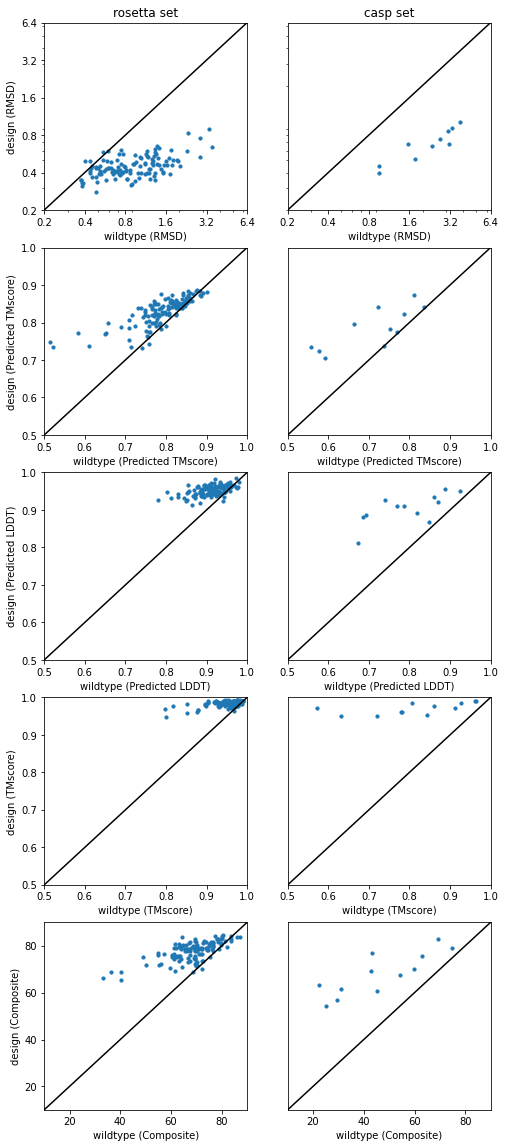

In [ ]:
plt.figure(figsize=(8,5*4))
full_metric = {"ptm":"Predicted TMscore",
               "plddt":"Predicted LDDT",
               "tm_io":"TMscore",
               "composite":"Composite",
               "rmsd_io":"RMSD"}
for f,metric in enumerate(["rmsd_io","ptm","plddt","tm_io","composite"]):
  for k in [0,1]:
    plt.subplot(5,2,f*2+k+1)
    if f == 0:
      plt.title(["rosetta set","casp set"][k])
    a,b = for_plot(k, metric=metric)
    if metric == "composite":
      a = a * 100
      b = b * 100
    plt.scatter(a, b.mean(-1),s=10)
    plt.plot([0,100],[0,100],color="black")
    plt.xlabel(f"wildtype ({full_metric[metric]})");
    if k == 0:
      plt.ylabel(f"design ({full_metric[metric]})")
    if metric == "composite":
      plt.xlim(10,90); plt.ylim(10,90);
      plt.xticks([20,40,60,80])
      if k == 0:
        plt.yticks([20,40,60,80])
      else:
        plt.yticks([])
    elif metric == "rmsd_io":
      plt.xlim(0.2,6.4);plt.ylim(0.2,6.4);
      plt.xscale("log");plt.yscale("log");
      plt.xticks([0.2,0.4,0.8,1.6,3.2,6.4],[0.2,0.4,0.8,1.6,3.2,6.4])
      if k == 0:
        plt.yticks([0.2,0.4,0.8,1.6,3.2,6.4],[0.2,0.4,0.8,1.6,3.2,6.4])
      else:
        plt.yticks([])
    else:
      plt.xlim(0.5,1);plt.ylim(0.5,1);
      if k == 1:
        plt.yticks([])

plt.savefig(f"rescore_designs.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()